<a href="https://colab.research.google.com/github/t-frank-unsw/zzsc9020-teamc/blob/main/src/zzsc9020%20-%20exploratory%20analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/UNSW-ZZSC9020/project/blob/main/src/GoogleColab.ipynb" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Welcome to ZZSC9020

This Python notebook shows how to clone the course GitHub repository on Google Colab.

You can develop your data analysis on Google Colab without downloading the data to your computer.

In [7]:
# Clone the group C repo
!git clone https://github.com/zzsc9020-teamc/project.git

# Make a data folder
!mkdir -p data

# Join the forecast demand parts into a single zip
!cat project/data/NSW/forecastdemand_nsw.csv.zip.part* > data/forecastdemand_nsw.csv.zip

# Unzip the three data files into the data folder
!unzip data/forecastdemand_nsw.csv.zip -d data
!unzip project/data/NSW/temperature_nsw.csv.zip -d data
!unzip project/data/NSW/totaldemand_nsw.csv.zip -d data

# Clean up the joined zip
!rm data/forecastdemand_nsw.csv.zip

# Quick check: list the data files
!ls -lh data


fatal: destination path 'project' already exists and is not an empty directory.
Archive:  data/forecastdemand_nsw.csv.zip
replace data/forecastdemand_nsw.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
Archive:  project/data/NSW/temperature_nsw.csv.zip
replace data/temperature_nsw.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
Archive:  project/data/NSW/totaldemand_nsw.csv.zip
replace data/totaldemand_nsw.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
total 718M
-rw-rw-r-- 1 root root 706M Apr 21  2021 forecastdemand_nsw.csv
-rw-rw-r-- 1 root root 6.6M Apr 21  2021 temperature_nsw.csv
-rw-rw-r-- 1 root root 5.6M Apr 21  2021 totaldemand_nsw.csv


In [9]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt

PATH_FORECAST = "data/forecastdemand_nsw.csv"
PATH_TEMP     = "data/temperature_nsw.csv"
PATH_ACTUAL   = "data/totaldemand_nsw.csv"

def dt_dayfirst(s):
    return pd.to_datetime(s, errors="coerce", dayfirst=True, infer_datetime_format=True)

def dt_us(s):
    s = s.astype(str).str.strip().str.replace(r"(\d{1,2})/(\d{1,2})/(\d{2})(?!\d)", r"\1/\2/20\3", regex=True)
    return pd.to_datetime(s, errors="coerce", dayfirst=False, infer_datetime_format=True)

# daily actual peak
a = (pd.read_csv(PATH_ACTUAL, usecols=["DATETIME","TOTALDEMAND","REGIONID"])
      .query("REGIONID=='NSW1'").drop(columns="REGIONID"))
a["DATETIME"] = dt_dayfirst(a["DATETIME"])
a["ACTUAL"] = pd.to_numeric(a["TOTALDEMAND"], errors="coerce")
a = a.dropna(subset=["DATETIME","ACTUAL"])
a["DATE"] = a["DATETIME"].dt.floor("D")
daily_actual = a.groupby("DATE", as_index=False)["ACTUAL"].max().rename(columns={"ACTUAL":"ACTUAL_PEAK"})

# daily max temp
t = pd.read_csv(PATH_TEMP).rename(columns={"TemperatureTEMPERATURE":"TEMPERATURE"})
t["DATETIME"] = dt_dayfirst(t["DATETIME"])
t["TEMPERATURE"] = pd.to_numeric(t["TEMPERATURE"], errors="coerce")
t = t.dropna(subset=["DATETIME","TEMPERATURE"])
t["DATE"] = t["DATETIME"].dt.floor("D")
daily_temp = t.groupby("DATE", as_index=False)["TEMPERATURE"].max().rename(columns={"TEMPERATURE":"TEMP_MAX"})

# Forecast max from day before
f = (pd.read_csv(PATH_FORECAST, usecols=["DATETIME","FORECASTDEMAND","REGIONID","LASTCHANGED"])
      .query("REGIONID=='NSW1'").drop(columns="REGIONID"))
f["DATETIME"]    = dt_us(f["DATETIME"])
f["LASTCHANGED"] = dt_us(f["LASTCHANGED"])
f["FORECASTDEMAND"] = pd.to_numeric(f["FORECASTDEMAND"], errors="coerce")
f = f.dropna(subset=["DATETIME","LASTCHANGED","FORECASTDEMAND"])
f["DATE_TARGET"] = f["DATETIME"].dt.floor("D")
f["DATE_ISSUE"]  = f["LASTCHANGED"].dt.floor("D")
f_day_ahead = f.loc[f["DATE_ISSUE"].eq(f["DATE_TARGET"] - pd.Timedelta(days=1))]
daily_forecast = (f_day_ahead.groupby("DATE_TARGET", as_index=False)["FORECASTDEMAND"]
                  .max().rename(columns={"DATE_TARGET":"DATE","FORECASTDEMAND":"FORECAST_PEAK_24H"}))

# Merge
daily = (daily_actual.merge(daily_temp, on="DATE", how="left")
                     .merge(daily_forecast, on="DATE", how="left"))
daily["ERROR"] = daily["ACTUAL_PEAK"] - daily["FORECAST_PEAK_24H"]
daily["YEAR"]  = daily["DATE"].dt.year

/tmp/ipython-input-3336275607.py:8: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.to_datetime(s, errors="coerce", dayfirst=True, infer_datetime_format=True)
/tmp/ipython-input-3336275607.py:8: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.to_datetime(s, errors="coerce", dayfirst=True, infer_datetime_format=True)
/tmp/ipython-input-3336275607.py:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-co

In [ ]:
# Plot
def _quad_fit(x, y, n=200):
    x, y = np.asarray(x, float), np.asarray(y, float)
    m = np.isfinite(x) & np.isfinite(y)
    if m.sum() < 3: return np.array([]), np.array([])
    xm, xs = x[m].mean(), (x[m].std() or 1.0)
    coef = np.polyfit((x[m]-xm)/xs, y[m], deg=2)
    xg = np.linspace(x[m].min(), x[m].max(), n)
    return xg, np.polyval(coef, (xg-xm)/xs)

def plot_error_views(d, year=None, bins=7):
    d = d.loc[d["YEAR"].eq(year)] if year is not None else d
    d = d.dropna(subset=["TEMP_MAX","ERROR"]).copy()
    if d.empty: return
    x, e = d["TEMP_MAX"].to_numpy(), d["ERROR"].to_numpy()
    xg, e_fit = _quad_fit(x, e)

    fig, axs = plt.subplots(1,2, figsize=(14,6))
    axs[0].axhline(0, linewidth=1)
    axs[0].scatter(x, e, alpha=0.6, s=12, label="Error (Actual - Forecast 24h)")
    if xg.size: axs[0].plot(xg, e_fit, linewidth=2, label="Quadratic fit")
    axs[0].set_xlabel("Daily max temp (°C)"); axs[0].set_ylabel("Error (MW)")
    axs[0].set_title("Error vs max temp"); axs[0].legend(); axs[0].grid(True, alpha=0.3)

    edges = np.linspace(d["TEMP_MAX"].min(), d["TEMP_MAX"].max(), bins+1)
    d = d.assign(TEMP_BIN=pd.cut(d["TEMP_MAX"], bins=edges, include_lowest=True))
    g = d.groupby("TEMP_BIN", observed=True).agg(mean_error=("ERROR","median"),
                                                 count=("ERROR","size")).reset_index()

    axs[1].bar(np.arange(len(g)), g["mean_error"])
    axs[1].axhline(0, linewidth=1)
    axs[1].set_xticks(np.arange(len(g))); axs[1].set_xticklabels(g["TEMP_BIN"].astype(str), rotation=30, ha="right")
    axs[1].set_xlabel("Daily max temp bins (°C)"); axs[1].set_ylabel("Median error (MW)")
    axs[1].set_title(f"Median error by temperature bin (bins={bins})")
    for i, (val, cnt) in enumerate(zip(g["mean_error"], g["count"])):
        axs[1].text(i, val, f" n={cnt}", ha="center", va="bottom" if val>=0 else "top", fontsize=8)
    axs[1].grid(True, axis="y", alpha=0.3)
    plt.suptitle(f"NSW daily — Max temperature{' ('+str(year)+')' if year else ''}")
    plt.tight_layout(); plt.show()

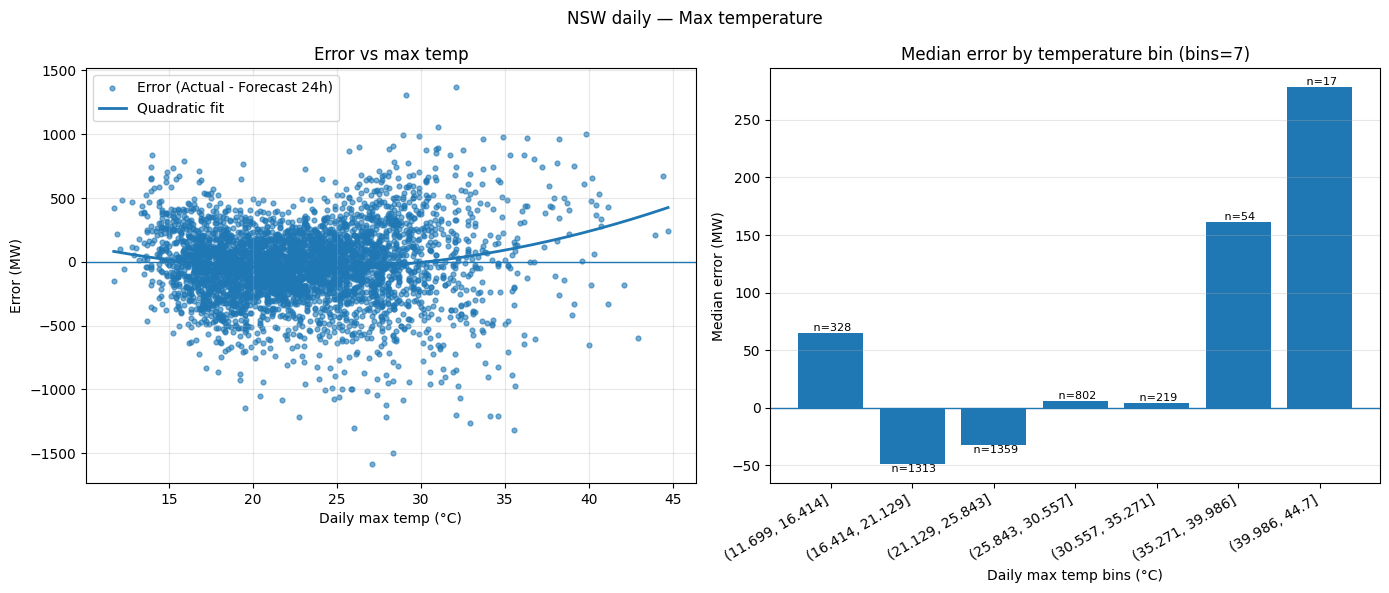

In [10]:
plot_error_views(daily)